In [1]:
import os
import cv2
import selectivesearch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

# Define the paths to the image folder and annotations
images_path = "../Potholes/annotated-images"
annotations_path = "../Potholes/annotated-images"

# Helper function to parse the XML file for ground truth bounding boxes
def parse_xml(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        boxes.append((xmin, ymin, xmax, ymax))
    return boxes


In [2]:
# Function to run Selective Search and obtain proposals
def get_proposals(image, scale=500, sigma=0.9, min_size=10):
    img_lbl, regions = selectivesearch.selective_search(image, scale=scale, sigma=sigma, min_size=min_size)
    proposals = []
    for r in regions:
        # Exclude duplicate regions
        if r['rect'] in proposals:
            continue
        x, y, w, h = r['rect']
        # Exclude small or invalid regions
        if w < 20 or h < 20 or w / h > 1.5 or h / w > 1.5:
            continue
        proposals.append((x, y, w, h))
    return proposals


In [3]:
# Function to calculate the IoU between two boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxA_Area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_Area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    if boxA_Area == 0 or boxB_Area == 0:
        return 0.0

    iou = interArea / float(boxA_Area + boxB_Area - interArea)
    return iou


In [4]:
# Function to evaluate proposals on a single image using recall
def calc_recall(proposals, ground_truth_boxes, iou_threshold):
    recalled_boxes = 0
    for gt_box in ground_truth_boxes:
        max_iou = 0
        for (x, y, w, h) in proposals:
            iou = calculate_iou(gt_box, (x, y, x + w, y + h))
            if iou > max_iou:
                max_iou = iou
        if max_iou >= iou_threshold:
            recalled_boxes += 1
    recall = recalled_boxes / len(ground_truth_boxes) if ground_truth_boxes else 0
    return recall

# Function to evaluate proposals on a single image using ABO
def calc_abo(proposals, ground_truth_boxes):
    sum_max_ious = 0
    for gt_box in ground_truth_boxes:
        max_iou = 0
        for (x, y, w, h) in proposals:
            iou = calculate_iou(gt_box, (x, y, x + w, y + h))
            max_iou = max(max_iou, iou)
        sum_max_ious += max_iou
    abo = sum_max_ious / len(ground_truth_boxes) if ground_truth_boxes else 0
    return abo


In [5]:
# Parameters for resizing images to improve efficiency
TARGET_WIDTH, TARGET_HEIGHT = 400, 400

# IoU threshold for "good" proposals
IOU_THRESHOLD = 0.5

# Number of proposals to evaluate
NUM_PROPOSALS_LIST = [50, 100, 200, 400, 800, 1000]

# Initialize lists to store metrics
average_recalls = []
average_abos = []
proposal_counts = []

# Loop through images
image_files = [f for f in os.listdir(images_path) if f.endswith(".jpg")]
total_images = len(image_files)
print(f"Total images: {total_images}")

for num_proposals in NUM_PROPOSALS_LIST:
    recalls = []
    abos = []
    for idx, image_filename in enumerate(image_files):
        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)

        # Read and resize image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image {image_path}")
            continue

        orig_height, orig_width = image.shape[:2]
        scale_x = TARGET_WIDTH / orig_width
        scale_y = TARGET_HEIGHT / orig_height
        resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))

        # Generate proposals
        proposals = get_proposals(resized_image)
        # Adjust proposals back to original image size
        adjusted_proposals = [(int(x / scale_x), int(y / scale_y), int(w / scale_x), int(h / scale_y)) for x, y, w, h in proposals]
        # Limit the number of proposals
        adjusted_proposals = adjusted_proposals[:num_proposals]

        # Parse ground truth boxes
        if os.path.exists(xml_path):
            gt_boxes = parse_xml(xml_path)
        else:
            print(f"Annotation file {xml_path} does not exist.")
            gt_boxes = []

        # Compute recall and ABO
        recall = calc_recall(adjusted_proposals, gt_boxes, IOU_THRESHOLD)
        abo = calc_abo(adjusted_proposals, gt_boxes)

        recalls.append(recall)
        abos.append(abo)

        # Progress update
        print(f"Processed image {idx+1}/{total_images} for {num_proposals} proposals.", end='\r')

    # Calculate average recall and ABO over all images
    average_recall = np.mean(recalls)
    average_abo = np.mean(abos)

    average_recalls.append(average_recall)
    average_abos.append(average_abo)
    proposal_counts.append(num_proposals)

    print(f"\nNumber of Proposals: {num_proposals}")
    print(f"Average Recall: {average_recall:.4f}")
    print(f"Average ABO: {average_abo:.4f}")


Total images: 665


c:\Users\Leuro\anaconda3\envs\DL\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed image 665/665 for 50 proposals.
Number of Proposals: 50
Average Recall: 0.3403
Average ABO: 0.3548
Processed image 665/665 for 100 proposals.
Number of Proposals: 100
Average Recall: 0.3470
Average ABO: 0.3581
Processed image 665/665 for 200 proposals.
Number of Proposals: 200
Average Recall: 0.3470
Average ABO: 0.3582
Processed image 665/665 for 400 proposals.
Number of Proposals: 400
Average Recall: 0.3470
Average ABO: 0.3582
Processed image 665/665 for 600 proposals.
Number of Proposals: 600
Average Recall: 0.3470
Average ABO: 0.3582
Processed image 665/665 for 800 proposals.
Number of Proposals: 800
Average Recall: 0.3470
Average ABO: 0.3582
Processed image 665/665 for 1000 proposals.
Number of Proposals: 1000
Average Recall: 0.3470
Average ABO: 0.3582
Processed image 665/665 for 1500 proposals.
Number of Proposals: 1500
Average Recall: 0.3470
Average ABO: 0.3582
Processed image 665/665 for 2000 proposals.
Number of Proposals: 2000
Average Recall: 0.3470
Average ABO: 0.35

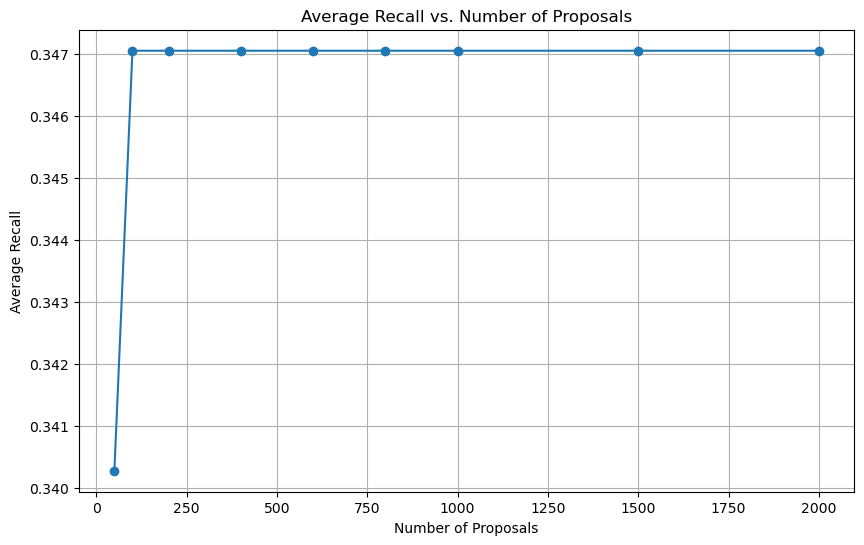

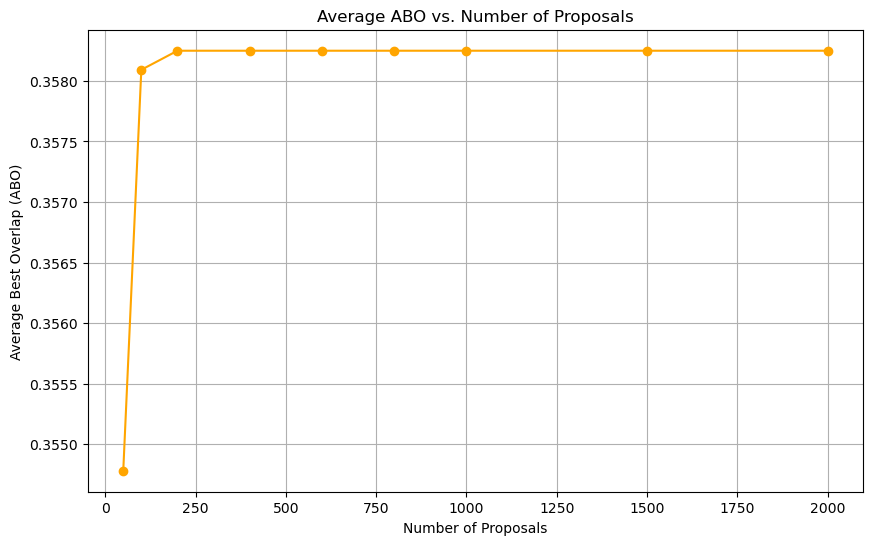

In [6]:
import matplotlib.pyplot as plt

# Plot Average Recall vs. Number of Proposals
plt.figure(figsize=(10, 6))
plt.plot(proposal_counts, average_recalls, marker='o')
plt.title('Average Recall vs. Number of Proposals')
plt.xlabel('Number of Proposals')
plt.ylabel('Average Recall')
plt.grid(True)
plt.show()

# Plot Average ABO vs. Number of Proposals
plt.figure(figsize=(10, 6))
plt.plot(proposal_counts, average_abos, marker='o', color='orange')
plt.title('Average ABO vs. Number of Proposals')
plt.xlabel('Number of Proposals')
plt.ylabel('Average Best Overlap (ABO)')
plt.grid(True)
plt.show()
